In [1]:
from sklearn.datasets import load_iris
import numpy as np

# Load the dataset
iris = load_iris()
X = iris['data']  # shape: (150, 4)
y = iris['target']

# Standardize features to [0.001, 0.999]
X_min = X.min(axis=0)
X_max = X.max(axis=0)

X_std = (X - X_min) / (X_max - X_min)  # Scales to [0, 1]
X_scaled = X_std * (0.999 - 0.001) + 0.001  # Scales to [0.001, 0.999]

# Check one sample
sample_index = 0
print("Original:", X[sample_index])
print("Standardized:", X_scaled[sample_index])


Original: [5.1 3.5 1.4 0.2]
Standardized: [0.22277778 0.62475    0.06866102 0.04258333]


In [2]:
index = 50  # choose any from 0 to 149
input_sample = X[index]     # shape: (4,) — 4 input features
output_label = y[index]     # scalar class label: 0, 1, or 2

print("Input sample:", input_sample)
print("Target class:", output_label)


for i in range(len(X)):
    inputs = X[i]
    label = y[i]
    # use inputs and label as needed



Input sample: [7.  3.2 4.7 1.4]
Target class: 1


In [ ]:
weight = [.5]

In [ ]:
# cost function basics
import numpy as np


corrected_result = [0.9]

# Sigmoid and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    s = sigmoid(x)
    return s * (1 - s)




# Inputs
x = np.array([0.2])  
target = np.array([0.9])  

# Weights for 3 output neurons (shape: (3, 2))
W = np.array([.5])
print(W)

# Forward pass
# z = W @ x  # shape: (3,)
# y = sigmoid(z)
# y is just current activation 


# Compute cost (MSE)
cost = np.mean((y - target)**2)

# Backward pass: gradient of cost w.r.t. output
dCost_dy = 2 * (y - target) / y.size

# Gradient of output w.r.t. z (because y = sigmoid(z))
dy_dz = sigmoid_deriv(z)

# Gradient of cost w.r.t. z
dCost_dz = dCost_dy * dy_dz  # shape: (3,)

# Gradient of cost w.r.t. weights
# We need outer product of dCost_dz (3,) and x (2,)
dCost_dW = np.outer(dCost_dz, x)  # shape: (3, 2)

# Update weights
learning_rate = 0.1
W -= learning_rate * dCost_dW

print(W)


[[ 0.2 -0.3]
 [ 0.4  0.1]
 [-0.5  0.2]]
[[ 0.20401597 -0.29919681]
 [ 0.39544781  0.09908956]
 [-0.49541714  0.20091657]]


In [25]:
weight = 0.5

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]


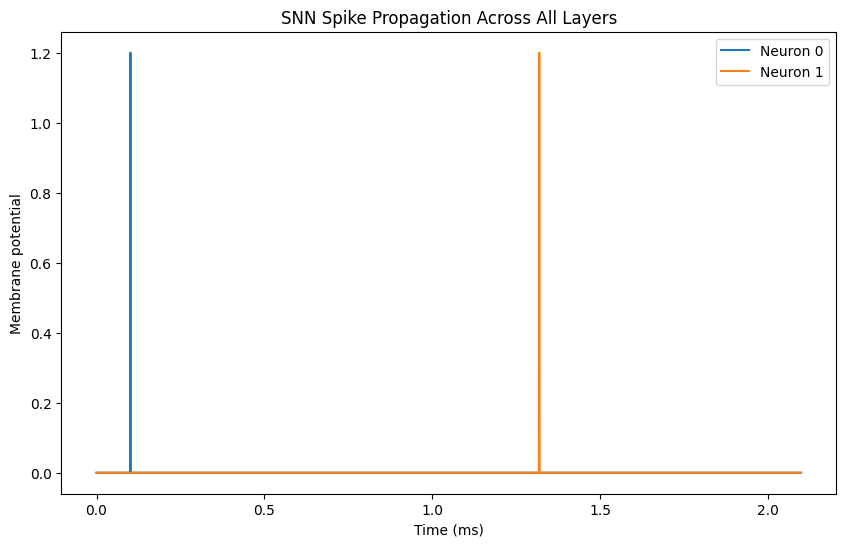

Neuron 0 spike times: ['0.101 ms']
Neuron 1 spike times: ['1.319 ms']


In [40]:
# Basic example of 2 neurons with weight applied and repeat runs to correct weight in back prop

from brian2 import *
import numpy as np

start_scope()

defaultclock.dt = 0.0001*ms  

# Custom timing function
@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1, sum=1, spikes_received=1)
def spike_timing(w, global_clock, layer, sum, spikes_received): 
    #print(global_clock)
    x = global_clock % 1
    if w >= 0:
        return (x ** (1 - w)) 
    else:
        return (1 - (1 - x) ** (1 + w)) 
    
@implementation('numpy', discard_units=True)
@check_units(layer=1, result=1, sum=1, spikes_received=1)
def math1(layer, sum, spikes_received): 
    return (sum/spikes_received )+ layer


n_input = 1
n_output = 1
n_total = n_input + n_output

# Full neuron group
neurons = NeuronGroup(n_total, '''
    v : 1
    sum : 1
    spikes_received : 1
    scheduled_time : second
    global_clock : 1
''', threshold='v > 1', reset='v = 0', method='exact')

neurons.v = 0
neurons.scheduled_time = 1e9 * second
neurons.global_clock = 0.0
neurons.sum = 0.0
neurons.spikes_received = 0.0

# Spike inputs (one per input neuron)     times=[i*0.4 for i in range(n_input)]
stim = SpikeGeneratorGroup(n_input, indices=range(n_input), times=([.1] * ms))

# Input → Hidden connections
syn_input = Synapses(stim, neurons[0:1], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms 
''')
syn_input.connect()

# Output layer: hidden → output
syn_output = Synapses(neurons[0], neurons[1], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms 
   
''')
syn_output.connect()
syn_output.w = weight # np.random.uniform(-0.90, .90, size=1) # [ 0.7116071 , -1.1385437 , -1.088651, 0.43341887, -1.4892002 , -1.3539809 ,0.28178445,  0.152175  , -0.54456943, -1.5054257 ,  0.12284008,  0.49124786, -0.41317764,  0.5724888 ,  0.4868003, 0.38319886,  0.31672755,  0.5698485, -0.7893439 , -0.4332046 ,  1.1470755, -0.619324  , -0.6091148 , -0.2407385, -0.02582   , -0.17720485,  0.3123896, -0.01638766,  0.39673412, -0.4153284 ]
#np.random.uniform(0.10, .90, size=30)
syn_output.layer = 1

# Scheduled activation & clock update
neurons.run_regularly('''
    v = int(abs(t - scheduled_time) < 0.0005*ms) * 1.2
                      
    global_clock += 0.001
''', dt=0.001*ms)

# Monitors
mon = StateMonitor(neurons, 'v', record=True, dt=0.001*ms)
mon_sum = StateMonitor(neurons, 'sum', record=True)
sp_mon = StateMonitor(neurons, 'spikes_received', record=True)
sch_time = StateMonitor(neurons, 'scheduled_time', record=True)


spikemon = SpikeMonitor(neurons)


run(2.1*ms)

# # Plot voltages
figure(figsize=(10, 6))
for i in range(n_total):  # All neurons
    plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
xlabel('Time (ms)')
ylabel('Membrane potential')
legend()
title('SNN Spike Propagation Across All Layers')
show()

#plot(mon_sum.t/ms, mon_sum.sum[4])  # or any neuron index
# print(mon_sum.sum[1])
# print(sp_mon.spikes_received[1])
# print(sch_time.scheduled_time[1])

sp_1 = 0.0
sp_2 = 0.0
for i in range(n_total):
    times = spikemon.spike_trains()[i]
    if len(times) > 0:
        formatted_times = [f"{t/ms:.3f} ms" for t in times]
        print(f"Neuron {i} spike times: {formatted_times}")
        if i == 0:
            sp_1 = times/ms 
        else:
            sp_2 = times/ms




In [98]:
import numpy as np

# Your spike_timing function
def spike_timing(w, global_clock, layer, sum, spikes_received): 
    x = global_clock % 1
    if w >= 0:
        return x ** (1 - w)
    else:
        return 1 - (1 - x) ** (1 + w)

# --- Inputs ---
global_clock = 0.1
layer = 1
sum_val = 0
spikes_received = 1

# Initial weight and target
desired_output = [0.9]

# --- Step 1: Forward Pass ---
output_spike_time = spike_timing(weight, global_clock, layer, sum_val, spikes_received)
print("Output spike time:", output_spike_time)

# --- Step 2: Cost ---
def calc_cost(output, desired):
    return 0.5 * ((output - desired[0]) ** 2)

cost = calc_cost(output_spike_time, desired_output)
print("Cost:", cost)

# --- Step 3: Numerical Gradient ---
epsilon = 0.0001
new_output = spike_timing(weight + epsilon, global_clock, layer, sum_val, spikes_received)
grad_approx = (new_output - output_spike_time) / epsilon  # d(output)/d(w)

# --- Step 4: Chain Rule ---
dC_dy = output_spike_time - desired_output[0]  # dCost/dOutput
dC_dw = dC_dy * grad_approx  # dCost/dWeight

# --- Step 5: Update ---
learning_rate = 0.1
weight -= learning_rate * dC_dw
print("Updated weight:", weight)


Output spike time: 0.8999999998704264
Cost: 8.39465555155096e-21
Updated weight: 0.9542425094036542
